## Использованные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
import statsmodels.stats.proportion as proportion
from scipy.stats import norm, shapiro, ttest_ind, levene
from tqdm.auto import tqdm
from numba import vectorize
import plotly.express as px

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Описание задачи

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:<br>
1) Был ли эксперимент успешен в целом.<br>
2) Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

## Описание данных

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

##### users_*.csv – информация о пользователях:

uid – идентификатор пользователя<br>
age – возраст<br>
attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки\просмотры*1000)<br>
coins – число монеток (внутренняя валюта)<br>
country – страна<br>
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)<br>
gender – пол<br>
age_filter_start  – фильтр поиска, мин. значение<br>
age_filter_end  – фильтр поиска, макс. значение<br> 
views_count – число полученных оценок<br> 
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)<br>
is_premium –  является ли премиум<br>
total_revenue – нормированная выручка<br> 


#### transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя<br>
country – страна<br>
joined_at – дата и время регистрации<br>
paid_at – дата и время покупки<br>
revenue – нормированная выручка<br>
payment_id – идентификатор платежа<br>
from_page – откуда пользователь перешел на страницу оплаты<br>
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)<br> 

## Выбор метрик

В данном кейсе мы имеем дело с A/A/B -тестом, поэтому прежде всего необходимо проверить корректность работы системы сплитования: если она работает корректно, то можно будет изучать данные тестовой группы.

1. Был ли эксперимент успешен в целом.<br>

Для начала выберем метрики для ответа на первый вопрос. Поскольку ключевое изменение в эксперименте - изменение в платёжной системе (в частности, изменение стоимости покупки), то в качестве ключевой метрики мы будем использовать **конверсию в покупку премиум-подписки**: гипотеза Ho - конверсия в покупку не изменилась, H1 - изменения повлияли на показатели конверсии.

Кроме этого, мы будем следить за динамикой дополнительных метрик: **retention** - поскольку дейтинговые приложения предполагают ежедневное использование и нам необходимо, чтобы данный показатель не падал; кроме того сравним наши выборки по показателю **среднего total revenue** - этот показатель одновремененно отражает множественный характер источников доходов, находится в зависимости от целевого изменения и хорошо подходит для проверки статистическими тестами для оценки средних.

2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.<br>

Для ответа на данный вопрос, мы также будем отслеживать 1 ключевую и 2 дополнительные метрики, выбранные на предыдущем шаге. Важно изучать динамику по тем группам, на которые мы можем каким-либо образом влиять. В качестве анализируемых групп выберем<br>

1) Страна - поскольку экспериментальные изменения коснулись не всех стран, важно изучить изменения между странамим.<br>
2) Источник трафика (from_page – откуда пользователь перешел на страницу оплаты) - на этот показатель мы можем влиять с помощью управления рекламными бюджетами.<br>
3) Пол и возраст пользователей - на данные показатели мы также можем влиять с помощью маркетингового позиционирования<br>

## Exploratory Data Analysis

In [2]:
def get_users(data_url):
    """Функция используется для считывания датафреймов с пользователями """    
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=data_url)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    df = pd.read_csv(download_url, sep=';')
    return df

def get_transactions(data_url):
    """Функция используется для считывания датафреймов с транзакциями, в отличии от пользователей - парсит даты""" 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=data_url)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    df = pd.read_csv(download_url, sep=';', parse_dates=['joined_at', 'paid_at'])
    return df

In [3]:
url_users_test = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'
url_transactions_test = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
url_users_control_1 = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
url_transactions_control_1 = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
url_users_control_2 = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
url_transactions_control_2 = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

In [4]:
users_test = get_users(url_users_test)
transactions_test = get_transactions(url_transactions_test)
users_control_1 = get_users(url_users_control_1)
transactions_control_1 = get_transactions(url_transactions_control_1)
users_control_2 = get_users(url_users_control_2)
transactions_control_2 = get_transactions(url_transactions_control_2)

##### Проверяем наши данные на пропущенные значения в датафреймах, описывающих пользователей

In [5]:
users_test.isna().sum().to_frame()

0
uid                  0
age                  0
attraction_coeff     0
coins             4259
country              0
visit_days        1330
gender               0
age_filter_start     0
age_filter_end       0
views_count          0
was_premium       3900
is_premium        4151
total_revenue        0

In [6]:
users_control_1.isna().sum().to_frame()

0
uid                  0
age                  0
attraction_coeff     0
coins             4280
country              0
visit_days        1324
gender               0
age_filter_start     0
age_filter_end       0
views_count          0
was_premium       3904
is_premium        4148
total_revenue        0

In [7]:
users_control_2.isna().sum().to_frame()

0
uid                  0
age                  0
attraction_coeff     0
coins             4203
country              0
visit_days        1364
gender               0
age_filter_start     0
age_filter_end       0
views_count          0
was_premium       3853
is_premium        4073
total_revenue        0

Во всех датафреймах мы видим пропущенные значения в колонках coins, visit_days, was_premium и is_premium.
Нас это устраивает, поскольку отсутствие данных в по этим колонкам означает лишь, что у пользователя никогда не было коинов, он ни разу не вернулся в приложение, никогда не имел премиум доступ или не имеет его в данный момент.

##### Проверяем наши данные на пропущенные значения в датафреймах, описывающих транзакции

In [8]:
transactions_test.isna().sum().to_frame()

0
uid           0
country       0
joined_at     0
paid_at       0
revenue       0
payment_id    0
from_page     0
product_type  0

In [9]:
transactions_control_1.isna().sum().to_frame()

0
uid           630
country       630
joined_at     630
paid_at       630
revenue       630
payment_id    630
from_page     630
product_type  630

In [10]:
transactions_control_2.isna().sum().to_frame()

0
uid           0
country       0
joined_at     0
paid_at       0
revenue       0
payment_id    0
from_page     0
product_type  0

В датафрейме с первой контрольной группой оказалось 630 пустых строк, избавимся от этой проблемы

In [11]:
transactions_control_1 = transactions_control_1.dropna()

In [12]:
transactions_control_1.isna().sum().to_frame()

0
uid           0
country       0
joined_at     0
paid_at       0
revenue       0
payment_id    0
from_page     0
product_type  0

##### Изучаем типы данных

In [13]:
print(users_test.dtypes)
print('')
print(users_control_1.dtypes)
print('')
print(users_control_2.dtypes)

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end    

In [14]:
print(transactions_test.dtypes)
print('')
print(transactions_control_1.dtypes)
print('')
print(transactions_control_2.dtypes)

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

uid                    float64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                float64
payment_id             float64
from_page               object
product_type            object
dtype: object

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object


В transactions_control_1 колонка uid почему-то имеет формат float64, а не int64: чтобы в будущем у нас не было отображения uid со знаками после запятой - изменим формат на int64

In [15]:
transactions_control_1.uid = transactions_control_1.uid.astype(int)

##### Оценим время, за которое у нас имеются данные

In [16]:
transactions_control_1.joined_at.min()

Timestamp('2015-01-19 11:49:00')

In [17]:
transactions_control_1.joined_at.max()

Timestamp('2017-10-31 22:17:00')

In [18]:
transactions_control_2.joined_at.min()

Timestamp('2017-01-11 08:36:00')

In [19]:
transactions_control_1.joined_at.max()

Timestamp('2017-10-31 22:17:00')

In [20]:
transactions_test.joined_at.min()

Timestamp('2017-01-11 03:07:00')

In [21]:
transactions_test.joined_at.max()

Timestamp('2017-10-31 23:40:00')

Судя по данным тестовой группы, эксперимент проходил с 11 января по 31 октября 2017 года, эти же данные подтверждает вторая контрольная группа. В первую контрольную группу попал пользователь, с датой регистрации в 2015 году, что не подходит под условия нашего эксперимента - изменения касались только новых пользователей. Однако, на всякий случай проверим также дату первых транзакций.

In [22]:
transactions_control_1.paid_at.min()

Timestamp('2016-12-14 16:16:00')

In [23]:
transactions_control_2.paid_at.min()

Timestamp('2017-01-11 05:34:00')

In [24]:
transactions_test.paid_at.min()

Timestamp('2017-01-11 04:37:00')

И в самом деле, в первую контрольную группу вошли пользователи с более ранней датой регистрации и покупки - очистим наши данные от этих выбросов.

In [25]:
transactions_control_1 = transactions_control_1.query('joined_at > "2017-01-10"')

In [26]:
transactions_control_1.joined_at.min()

Timestamp('2017-01-11 01:06:00')

In [27]:
transactions_control_1.paid_at.min()

Timestamp('2017-01-11 02:56:00')

##### Изучаем размер датафреймов

In [28]:
print(f'users_test      содержит {users_test.shape[0]} строк')
print(f'users_control_1 содержит {users_control_1.shape[0]} строк')
print(f'users_control_2 содержит {users_control_2.shape[0]} строк')

users_test      содержит 4308 строк
users_control_1 содержит 4340 строк
users_control_2 содержит 4264 строк


In [29]:
print(f'transactions_test      содержит {transactions_test.shape[0]} строк')
print(f'transactions_control_1 содержит {transactions_control_1.shape[0]} строк')
print(f'transactions_control_2 содержит {transactions_control_2.shape[0]} строк')

transactions_test      содержит 273 строк
transactions_control_1 содержит 374 строк
transactions_control_2 содержит 328 строк


Объём выборок в тестовой и контрольных группах сравнимы, также как и количество транзакций

##### Взглянем на  количество пользователей, совершавших повторные транзакции в каждой из групп

In [30]:
transactions_test.groupby('uid').agg({'country': 'count'}).query('country > 1').shape[0]

50

In [31]:
transactions_control_1.groupby('uid').agg({'country': 'count'}).query('country > 1').shape[0]

62

In [32]:
transactions_control_2.groupby('uid').agg({'country': 'count'}).query('country > 1').shape[0]

65

Взглянем на пример пользователя со множеством транзакций из тестовой группы

In [33]:
transactions_test.query('uid == "891174411"')

uid country           joined_at             paid_at  revenue  \
42   891174411  Israel 2017-08-11 07:24:00 2017-09-11 08:50:00     2743   
51   891174411  Israel 2017-08-11 07:24:00 2017-08-11 20:48:00     2743   
91   891174411  Israel 2017-08-11 07:24:00 2017-10-11 01:18:00     2730   
195  891174411  Israel 2017-08-11 07:24:00 2017-11-15 09:31:00    14404   
240  891174411  Israel 2017-08-11 07:24:00 2017-08-11 07:30:00     2743   
257  891174411  Israel 2017-08-11 07:24:00 2017-10-11 18:00:00     2717   

     payment_id     from_page   product_type  
42           67   empty_likes     other_type  
51           67   empty_likes     other_type  
91           67   empty_likes     other_type  
195         147  user_profile  trial_premium  
240          67   empty_likes     other_type  
257          67   empty_likes     other_type

Из примера можно увидеть, что повторные транзакции этот дополнительные покупки, кроме того, можно предположить, что такой транзакцией может быть покупка полной премиум подписки после окончания trial.

In [34]:
transactions_test.query('uid == "891174411"').revenue.sum()

28080

In [35]:
users_test.query('uid == "891174411"').total_revenue

3967    28080
Name: total_revenue, dtype: int64

Как можем увидеть, сумма revenue в датафрейме с транзакциями будет равна total_revenue из таблицы с описанием пользователей

##### Найдём количество пользователей, купивших премиум-подписку в каждой из групп

In [36]:
transactions_test.query('product_type == "premium_no_trial"').shape[0]

76

In [37]:
transactions_control_1.query('product_type == "premium_no_trial"').shape[0]

106

In [38]:
transactions_control_2.query('product_type == "premium_no_trial"').shape[0]

107

##### Техническая предобработка

Создаём столбец для расчёта окна конверсии

In [39]:
transactions_control_1['cr_win'] = transactions_control_1['paid_at'] - transactions_control_1['joined_at']
transactions_control_2['cr_win'] = transactions_control_2['paid_at'] - transactions_control_2['joined_at']
transactions_test['cr_win'] = transactions_test['paid_at'] - transactions_test['joined_at']

In [40]:
print(transactions_control_1['cr_win'].min())
print(transactions_control_2['cr_win'].min())
print(transactions_test['cr_win'].min())

-289 days +18:23:00
-293 days +21:12:00
-288 days +02:12:00


In [41]:
print(transactions_control_1['cr_win'].max())
print(transactions_control_2['cr_win'].max())
print(transactions_test['cr_win'].max())

306 days 16:58:00
214 days 02:04:00
302 days 00:42:00


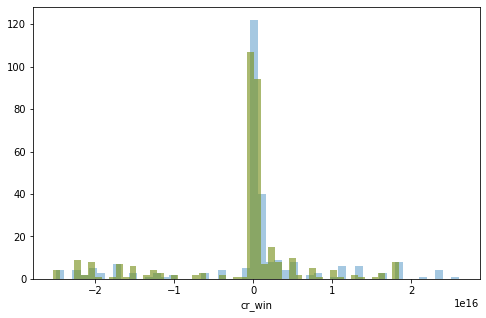

In [42]:
plt.figure(figsize=(8, 5))
sns.distplot(transactions_test.cr_win, kde=False)
sns.distplot(transactions_control_2.cr_win, kde=False)
sns.distplot(transactions_control_2.cr_win, kde=False)

Можно увидеть, что у нас есть очень поздние покупки - совершённые почти через год после регистрации.

Кроме этого, есть случаи, когда покупка была совершена раньше регистрации - этот случай более интересный и нам необходимо проверить является ли такое поведение системной ошибкой, или фичёй приложения.

In [43]:
print(transactions_control_1.query('cr_win < "0 days"').shape[0])
print(transactions_control_2.query('cr_win < "0 days"').shape[0])
print(transactions_test.query('cr_win < "0 days"').shape[0])

55
60
47


В каждом из датафреймов таких случаев много, значит в приложении присутствует возможность совершать покупки до регистрации.
Определённый смысл такое поведение может иметь: например, пользователи совершают покупку заранее по скидке, даже если не планируют сейчас пользоваться продуктом.

In [44]:
print(transactions_control_1.query('cr_win < "0 days" & product_type == "premium_no_trial"')['cr_win'].min())
print(transactions_control_2.query('cr_win < "0 days" & product_type == "premium_no_trial"')['cr_win'].min())
print(transactions_test.query('cr_win < "0 days" & product_type == "premium_no_trial"')['cr_win'].min())

-254 days +00:32:00
-292 days +22:15:00
-250 days +04:53:00


Максимум, сколько человек не регистрировался в приложении после совершения покупки составил 292 дня  и произошёл во второй контрольной группе. Данное значение меньше года - можно предположить, что в сервисе присуствует возможность купить годовую премиум-подписку.

Среди транзакций выделим только интересующие нас действия в покупку премиум-подписки, чтобы в будущем иметь возможность рассчитывать конверсию в это действие.

In [45]:
premium_test = transactions_test.query('product_type == "premium_no_trial"')
premium_control_1 = transactions_control_1.query('product_type == "premium_no_trial"')
premium_control_2 = transactions_control_2.query('product_type == "premium_no_trial"')

In [46]:
print(f'premium_test      содержит {premium_test.shape[0]} строк')
print(f'premium_control_1 содержит {premium_control_1.shape[0]} строк')
print(f'premium_control_2 содержит {premium_control_2.shape[0]} строк')

premium_test      содержит 76 строк
premium_control_1 содержит 106 строк
premium_control_2 содержит 107 строк


Повторно проверим на повторяющиеся значения

In [47]:
premium_test.groupby('uid').agg({'country': 'count'}).query('country > 1').count()

country    6
dtype: int64

In [48]:
premium_control_1.groupby('uid').agg({'country': 'count'}).query('country > 1').count()

country    7
dtype: int64

In [49]:
premium_control_2.groupby('uid').agg({'country': 'count'}).query('country > 1').count()

country    4
dtype: int64

Мне не вполне понятны источники задвоений в данных. В каких-то случаях платёж мог пройти не с первого раза, но в лог попали все попытки. <br> А в каких-то у пользователя могла закончиться подписка и он её обновлял, например пользователь 892366260 из 1 контрольной группы:

In [50]:
premium_control_1.query("uid == '892366260'").head()

uid                         country           joined_at  \
84   892366260  United Kingdom (Great Britain) 2017-10-15 15:04:00   
103  892366260  United Kingdom (Great Britain) 2017-10-15 15:04:00   

                paid_at  revenue  payment_id          from_page  \
84  2017-10-15 15:49:00   6292.0       147.0  left_sidebar_menu   
103 2017-11-14 16:50:00   6292.0       147.0  left_sidebar_menu   

         product_type           cr_win  
84   premium_no_trial  0 days 00:45:00  
103  premium_no_trial 30 days 01:46:00

Вероятнее всего, мы обнаружили баг в логировании данных и в реальной ситуации я бы пошёл к разработчикам, чтобы они его пофиксили. Для анализа в этом проекте, я просто отберу первые встречающиеся значения - поскольку эти данные всё равно нужны нам для рассчёта конверсии, то есть достаточно факта того, что пользователь купил премиум-подписку.<br> 

К сожалению, по имеющимся данным практически невозможно точно оценить, какие из повторяющихся транзакция являются реальными повторными покупками, а какие багом в логировании: даже предположение, что совершённые в один и тот же день две одинаковые транзакции это баг, а в разные дни - повторные платежи, остаётся лишь гипотезой, ведь можно предположить и такой сценарий, где платёж обрабатывается банком в течении нескольких дней, банк его отклоняет и происходит повторный запрос на списание средств. 

Мы точно знаем, что повторные транзакции учитываются при подсчёте total_revenue в таблицах users. Однако, с тем же успехом повторные транзакции могут реально снимать деньги с пользователя и переводить на наш счёт, то есть в итоге реально повышать total_revenue - узнать что произошло на самом деле по имеющися данным невозможно. Именно поэтому я **буду принебрегать фактом того, что повторные транзакции могут быть багом, который искуственно завышает total revenue**, тем более, что это лишь одна из статей доходов, а случаев повторных транзакций не так и много и они относительно однородно распределены между подвыборками.

Для расчёта конверсии нам понадобятся датафреймы для пользователей, дополненные данными о том, когда данный пользователь совершил первую покупку премиум-подписки, создадим их.

In [51]:
pr_1_date = premium_test.groupby('uid')\
                        .agg({'paid_at': 'min', 'payment_id': 'min'})\
                        .reset_index()\
                        .rename(columns={'paid_at': 'first_paid', 'payment_id': 'min_pay_id'})
premium_test = premium_test.merge(pr_1_date, on='uid', how='inner')
pr_с1_date = premium_control_1.groupby('uid')\
                              .agg({'paid_at': 'min', 'payment_id': 'min'})\
                              .reset_index()\
                              .rename(columns={'paid_at': 'first_paid', 'payment_id': 'min_pay_id'})
premium_control_1 = premium_control_1.merge(pr_с1_date, on='uid', how='inner')
pr_с2_date = premium_control_2.groupby('uid')\
                              .agg({'paid_at': 'min', 'payment_id': 'min'})\
                              .reset_index()\
                              .rename(columns={'paid_at': 'first_paid', 'payment_id': 'min_pay_id'})
premium_control_2 = premium_control_2.merge(pr_с2_date, on='uid', how='inner')
premium_control = pd.concat([premium_control_1, premium_control_2])

In [52]:
test_aab = premium_test.query('paid_at == first_paid & payment_id == min_pay_id')
control_1_aab = premium_control_1.query('paid_at == first_paid & payment_id == min_pay_id')
control_2_aab = premium_control_2.query('paid_at == first_paid & payment_id == min_pay_id')
control_aab = pd.concat([control_1_aab, control_2_aab])

Проверка: после группировки по uid и агрегации через count средние будут равны единице, если дублирований нет

In [53]:
print(test_aab.groupby('uid').agg({'joined_at': 'count'}).mean())
print(control_1_aab.groupby('uid').agg({'joined_at': 'count'}).mean())
print(control_2_aab.groupby('uid').agg({'joined_at': 'count'}).mean())

joined_at    1.0
dtype: float64
joined_at    1.0
dtype: float64
joined_at    1.0
dtype: float64


Наконец-то формируем объединённые датафреймы, которые и будем использовать для расчётов конверсии

In [54]:
full_test = users_test.merge(test_aab, on='uid', how='left')
full_test = full_test.rename(columns={'country_x': 'country'})
full_test['test_group'] = 'test'

full_control_1 = users_control_1.merge(control_1_aab, on='uid', how='left')
full_control_1 = full_control_1.rename(columns={'country_x': 'country'})
full_control_1['test_group'] = 'control_1'


full_control_2 = users_control_2.merge(control_2_aab, on='uid', how='left')
full_control_2 = full_control_2.rename(columns={'country_x': 'country'})
full_control_2['test_group'] = 'control_2'

full = pd.concat([full_test, full_control_1, full_control_2])

Также создадим отдельные датафреймы для A/A-тестов (только контрольные группы) и A/B-тестов (с объединением контрольных групп в одну)

In [55]:
full_aa = pd.concat([full_control_1, full_control_2])
full_a = full_aa.copy()
full_a['test_group'] = 'control'
full_b = full.query('test_group == "test"')
full_ab = pd.concat([full_a, full_b])

## Конверсия

##### A/A-test

Для начала проверим результаты AA-теста, чтобы зафиксировать отсутствие разницы между контрольными группами

In [56]:
conversion_aa = full_aa.groupby('test_group', as_index=False)\
                       .agg({'uid': 'count', 'first_paid': 'count'})\
                       .rename(columns={'uid': 'all_users', 'first_paid': 'paid_users'})
conversion_aa['CR'] = round(conversion_aa.paid_users / conversion_aa.all_users * 100, 2)
conversion_aa

test_group  all_users  paid_users    CR
0  control_1       4340          98  2.26
1  control_2       4264         102  2.39

In [57]:
shi2stat_aa, pval_aa, xtable_aa = proportion.proportions_chisquare(conversion_aa.paid_users, conversion_aa.all_users)

In [58]:
pval_aa

0.6798988324414221

В случае сравнения двух контрольных групп мы не видим статистического различия между ними, значит система сплитования настроена правильно

##### A/B-test

In [59]:
conversion_ab = full_ab.groupby('test_group', as_index=False)\
                       .agg({'uid': 'count', 'first_paid': 'count'})\
                       .rename(columns={'uid': 'all_users', 'first_paid': 'paid_users'})
conversion_ab['CR'] = round(conversion_ab.paid_users / conversion_ab.all_users * 100, 2)
conversion_ab

test_group  all_users  paid_users    CR
0    control       8604         200  2.32
1       test       4308          67  1.56

In [60]:
shi2stat_ab, pval_ab, xtable_ab = proportion.proportions_chisquare(conversion_ab.paid_users, conversion_ab.all_users)

In [61]:
pval_ab

0.0037762270739562253

In [62]:
2.32 / 1.56

1.487179487179487

В случае A/B-теста Хи-квадрат показал статистически значимое отличие контрольной и тестовой групп

**Промежуточный итог:** показатель конверсии в покупку премиум-подписки в тестовой группе ниже в полтора раза, однако это не означает, что эксперимент не успешен. 

В условии не сказано, как именно изменилась цена подписки, эксперимент вполне мог быть направлен на повышение этой цены - что естественно скажется на конверсии. Повышение цены может быть вынужденным, или учитывая специфику продукта - способом экономического ценза аудитории, чтобы привлекать более успешных в социальном плане пользователей. Чтобы принять окончательное решение по эффективности эксперимента, необходимо проанализировать и другие метрики. А учитывая новое предположение предлагаю посмотреть изменение ещё одной метрики - ***среднего значения коэффициента привлекательности (attraction_coeff)***.

## Денежные метрики

## ARPU

Для того, чтобы понять, какой тест использовать - изучим характер данных распределений.

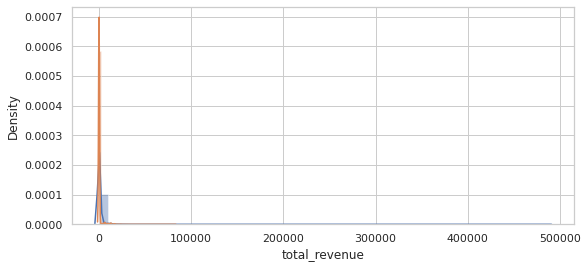

In [63]:
sns.set(rc={'figure.figsize': (9, 4)}, style="whitegrid")
sns.distplot(full_control_1['total_revenue'])
sns.distplot(full_control_2['total_revenue'])

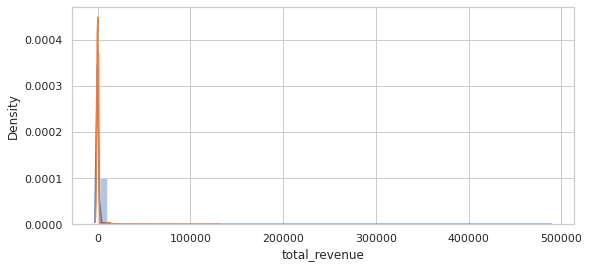

In [64]:
sns.set(rc={'figure.figsize': (9, 4)}, style="whitegrid")
sns.distplot(full_a['total_revenue'])
sns.distplot(full_b['total_revenue'])

In [65]:
print(shapiro(full_a['total_revenue']))
print(shapiro(full_b['total_revenue']))
print(shapiro(full_control_1['total_revenue']))
print(shapiro(full_control_2['total_revenue']))

ShapiroResult(statistic=0.04990106821060181, pvalue=0.0)
ShapiroResult(statistic=0.09913712739944458, pvalue=0.0)
ShapiroResult(statistic=0.03915470838546753, pvalue=0.0)
ShapiroResult(statistic=0.1445736289024353, pvalue=0.0)


Данные распределения, не являются нормальным, для них нельзя использовать t-test, поэтому для проверки наших гипотез необходимо использовать другие методы: t-test на логарифмированных данных, u-test или bootstrap. Поскольку мы всё же хотим сравнить средние - u-test для этих целей не подходит, ведь он сранивает характер распределения, а не средние. Проверим логарифмирование и bootstrap.

In [66]:
full_a['log_total_revenue'] = np.log(full_a['total_revenue'] + 1)
full_b['log_total_revenue'] = np.log(full_b['total_revenue'] + 1)
full_control_1['log_total_revenue'] = np.log(full_control_1['total_revenue'] + 1)
full_control_2['log_total_revenue'] = np.log(full_control_2['total_revenue'] + 1)

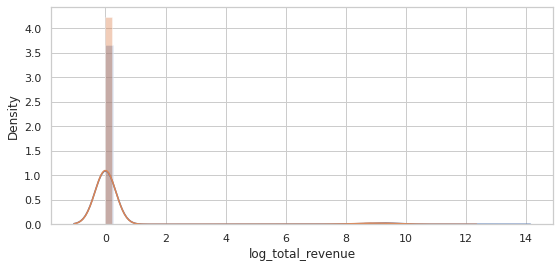

In [67]:
sns.set(rc={'figure.figsize': (9, 4)}, style="whitegrid")
sns.distplot(full_control_1['log_total_revenue'])
sns.distplot(full_control_2['log_total_revenue'])

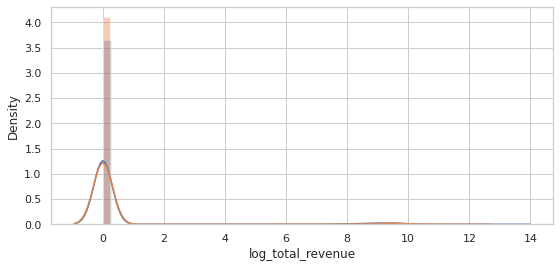

In [68]:
sns.set(rc={'figure.figsize': (9, 4)}, style="whitegrid")
sns.distplot(full_a['log_total_revenue'])
sns.distplot(full_b['log_total_revenue'])

In [69]:
print(shapiro(full_a['log_total_revenue']))
print(shapiro(full_b['log_total_revenue']))
print(shapiro(full_control_1['log_total_revenue']))
print(shapiro(full_control_2['log_total_revenue']))

ShapiroResult(statistic=0.20990729331970215, pvalue=0.0)
ShapiroResult(statistic=0.17578482627868652, pvalue=0.0)
ShapiroResult(statistic=0.21050536632537842, pvalue=0.0)
ShapiroResult(statistic=0.20920932292938232, pvalue=0.0)


Даже c помощью логарифмирования мы не смогли добиться того, чтобы наши распределения походили на нормальные, поэтому будем применять bootstrap.

In [70]:
def get_bootstrap(data_column_1, data_column_2, boot_it=10000, statistic=np.mean, bootstrap_conf_level=0.95):
    
    """Функция бустрапа для проверки статистических гипотез"""
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
    pd_boot_data = pd.DataFrame(boot_data)
       
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

##### A/A-test

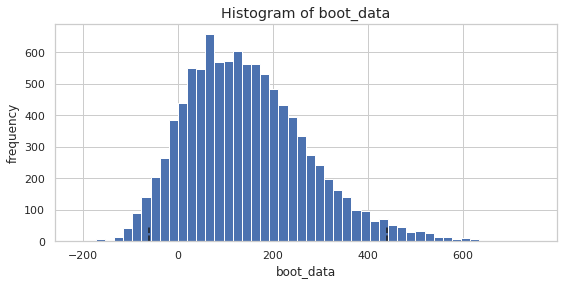

{'ci':                 0
 0.025  -62.298906
 0.975  439.883007,
 'p_value': 0.26124403930522555}

In [71]:
get_bootstrap(full_control_1['total_revenue'], full_control_2['total_revenue'])

Различий между контрольными выборками не наблюдается, можно продолжать проверку результатов эксперимента

##### A/B-test

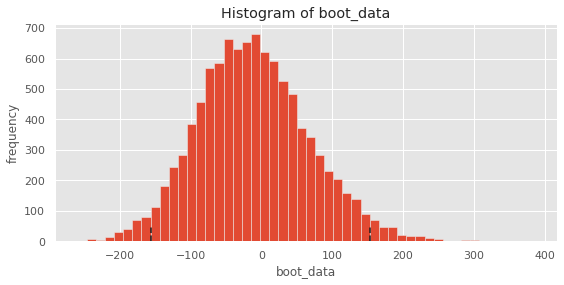

{'ci':                 0
 0.025 -155.968422
 0.975  153.989185,
 'p_value': 0.8892709142583658}

In [72]:
get_bootstrap(full_a['total_revenue'], full_b['total_revenue'])

Эксперимент показал, что средний доход с пользователя не изменился.

## ARPPU

In [73]:
arppu_a = full_a.query('revenue > 0')
arppu_b = full_a.query('revenue > 0')
arppu_c1 = full_control_1.query('revenue > 0')
arppu_c2 = full_control_2.query('revenue > 0')

**A/A-test**

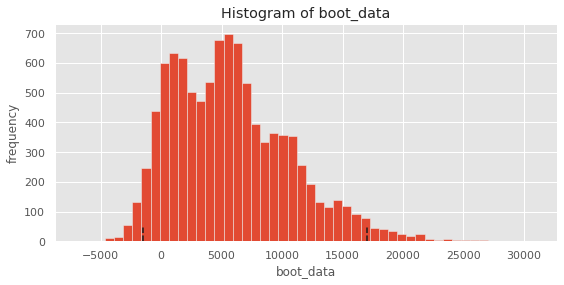

{'ci':                   0
 0.025  -1495.927206
 0.975  17034.476716,
 'p_value': 0.24384264424238622}

In [74]:
get_bootstrap(arppu_c1['total_revenue'], arppu_c2['total_revenue'])

**A/B - test**

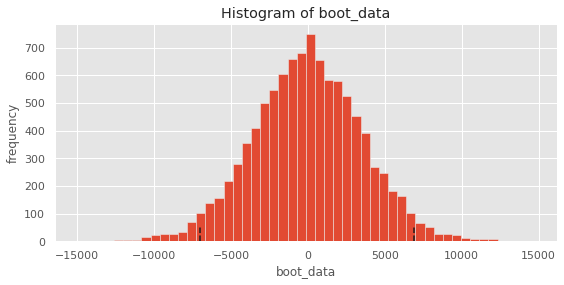

{'ci':                  0
 0.025 -7041.159125
 0.975  6903.487500,
 'p_value': 0.991835186003163}

In [75]:
get_bootstrap(arppu_a['total_revenue'], arppu_b['total_revenue'])

Эксперимент показал, что средний доход с платящего пользователя также не изменился. 

Однако, мы помним, что total_revenue состоит не только из платы за премиум-подписку, но также учитывает другие услуги, поэтому предлагаю также изучить средний показатель revenue среди тех, кто совершил целевое действие, на которое было направлено экспериментальное изменение -  купил платную-подписку.

## Влияние эксперимента на показатель revenue среди пользователей, оплативших премиум подписку

##### Изучаем распределения

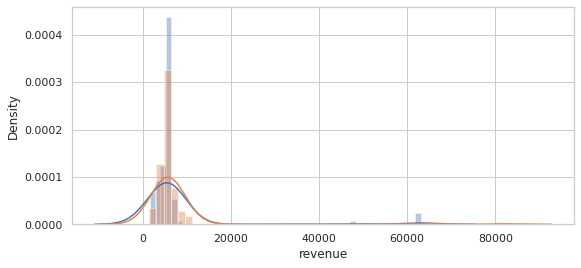

In [76]:
sns.set(rc={'figure.figsize': (9, 4)}, style="whitegrid")
sns.distplot(premium_control_1['revenue'])
sns.distplot(premium_control_2['revenue'])

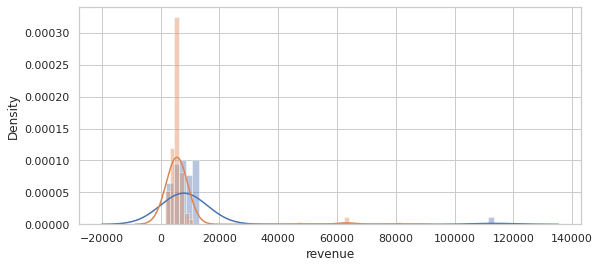

In [77]:
sns.set(rc={'figure.figsize': (9, 4)}, style="whitegrid")
sns.distplot(premium_test['revenue'])
sns.distplot(premium_control['revenue'])

В данных есть выбросы, однако в остальном распредления более похожи на нормальные, нежели total_revenue, проведём статесты на нормальность

In [78]:
print(shapiro(premium_test['revenue']))
print(shapiro(premium_control['revenue']))
print(shapiro(premium_control_1['revenue']))
print(shapiro(premium_control_2['revenue']))

ShapiroResult(statistic=0.2963985800743103, pvalue=2.6612618804233768e-17)
ShapiroResult(statistic=0.2687572240829468, pvalue=3.0731929307491015e-28)
ShapiroResult(statistic=0.29585927724838257, pvalue=2.847592200051099e-20)
ShapiroResult(statistic=0.23264849185943604, pvalue=3.8541353769882434e-21)


Тест Шапиро-Уилка показал, что все наши распределения revenue - не нормальные, поэтому для их проверки мы не можем использовать t-test, поэтому попробуем логарифмирование.

In [79]:
premium_test['log_revenue'] = np.log(premium_test['revenue'] + 1)
premium_control['log_revenue'] = np.log(premium_control['revenue'] + 1)
premium_control_1['log_revenue'] = np.log(premium_control_1['revenue'] + 1)
premium_control_2['log_revenue'] = np.log(premium_control_2['revenue'] + 1)

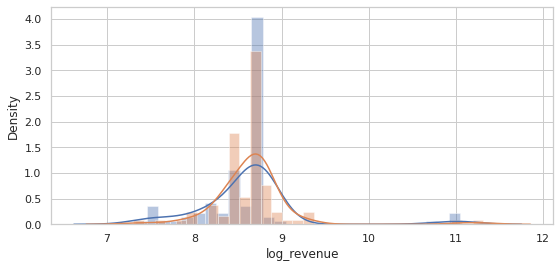

In [80]:
sns.set(rc={'figure.figsize': (9, 4)}, style="whitegrid")
sns.distplot(premium_control_1['log_revenue'])
sns.distplot(premium_control_2['log_revenue'])

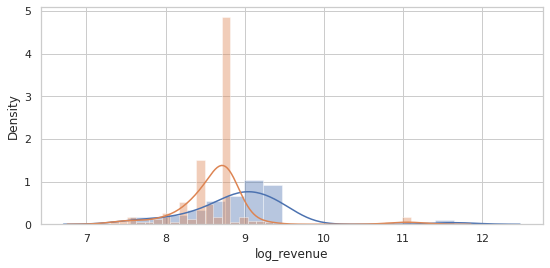

In [81]:
sns.set(rc={'figure.figsize': (9, 4)}, style="whitegrid")
sns.distplot(premium_test['log_revenue'])
sns.distplot(premium_control['log_revenue'])

In [82]:
print(shapiro(premium_test['log_revenue']))
print(shapiro(premium_control['log_revenue']))
print(shapiro(premium_control_1['log_revenue']))
print(shapiro(premium_control_2['log_revenue']))

ShapiroResult(statistic=0.8416124582290649, pvalue=1.5158418875671487e-07)
ShapiroResult(statistic=0.6837852001190186, pvalue=9.228176193892748e-20)
ShapiroResult(statistic=0.6834542751312256, pvalue=8.486576242097699e-14)
ShapiroResult(statistic=0.6796320676803589, pvalue=5.913040104213105e-14)


Здесь логарифмирование также не помогло, поэтому используем bootstrap

##### A/A-test

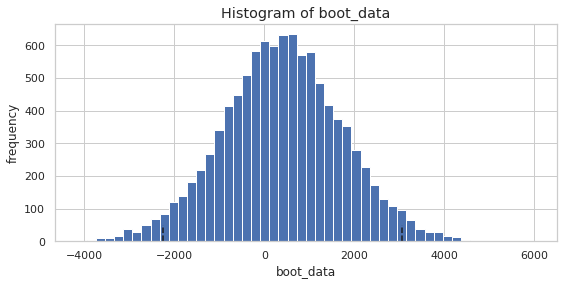

{'ci':                  0
 0.025 -2252.492991
 0.975  3051.494860,
 'p_value': 0.7652879212949616}

In [83]:
get_bootstrap(premium_control_1['revenue'], premium_control_2['revenue'])

Различий в контрольных группах нет

##### A/B-test

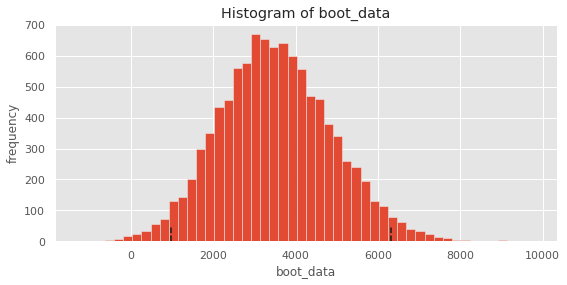

{'ci':                  0
 0.025   972.985915
 0.975  6319.615845,
 'p_value': 0.009970707306581833}

In [84]:
get_bootstrap(premium_test['revenue'], premium_control['revenue'])

Мы обнаружили статистически значимое различий в revenue между тестовой и контрольной группами.

In [85]:
print(premium_test['revenue'].mean())
print(premium_control['revenue'].mean())

10667.184210526315
7155.24882629108


In [189]:
t_mult = round(10667.184210526315 / 7155.24882629108, 2)
print(f'Среднее значение revenue для покупателей премиум подписки в тестовой группе увеличилось в {t_mult} раз')

Среднее значение revenue для покупателей премиум подписки в тестовой группе увеличилось в 1.49 раз


## А что с другими источниками дохода?

In [87]:
other_test = transactions_test.query('product_type == "other_type"')
other_test['test_group'] = 'test'
other_test['log_revenue'] = np.log(other_test.revenue + 1)
other_control_1 = transactions_control_1.query('product_type == "other_type"')
other_control_1['test_group'] = 'control_1'
other_control_1['log_revenue'] = np.log(other_control_1.revenue + 1)
other_control_2 = transactions_control_2.query('product_type == "other_type"')
other_control_2['test_group'] = 'other_control_2'
other_control_2['log_revenue'] = np.log(other_control_2.revenue + 1)
other_control = pd.concat([other_control_1, other_control_2])
other_control['test_group'] = 'control'
other_control['log_revenue'] = np.log(other_control.revenue + 1)

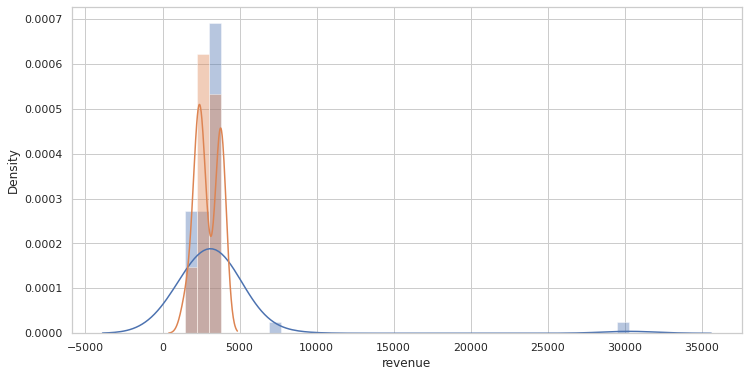

In [88]:
sns.set(rc={'figure.figsize': (12, 6)}, style="whitegrid")
sns.distplot(other_control_1['revenue'])
sns.distplot(other_control_2['revenue'])

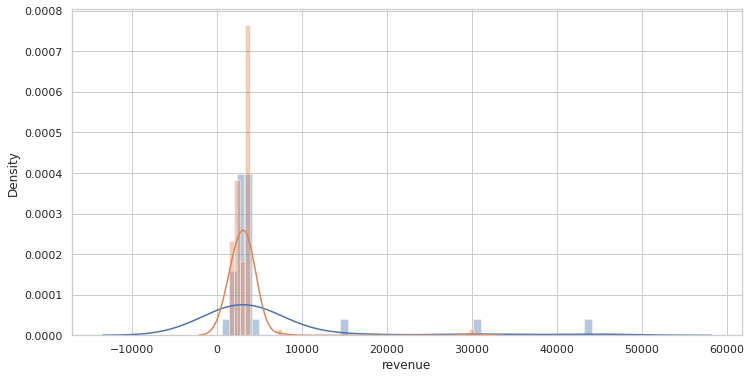

In [89]:
sns.set(rc={'figure.figsize': (12, 6)}, style="whitegrid")
sns.distplot(other_test['revenue'])
sns.distplot(other_control['revenue'])

In [90]:
print(shapiro(other_test['revenue']))
print(shapiro(other_control['revenue']))
print(shapiro(other_control_1['revenue']))
print(shapiro(other_control_2['revenue']))

ShapiroResult(statistic=0.4242846965789795, pvalue=1.3752545768852542e-09)
ShapiroResult(statistic=0.296581506729126, pvalue=2.437907026371145e-19)
ShapiroResult(statistic=0.3197682499885559, pvalue=3.897181310844912e-14)
ShapiroResult(statistic=0.8152902126312256, pvalue=6.392068826244213e-06)


In [91]:
print(shapiro(other_test['log_revenue']))
print(shapiro(other_control['log_revenue']))
print(shapiro(other_control_1['log_revenue']))
print(shapiro(other_control_2['log_revenue']))

ShapiroResult(statistic=0.7322536706924438, pvalue=6.321861292235553e-06)
ShapiroResult(statistic=0.771611213684082, pvalue=6.585432199557317e-11)
ShapiroResult(statistic=0.7485259175300598, pvalue=4.4792589193320964e-08)
ShapiroResult(statistic=0.8333070874214172, pvalue=1.6876463632797822e-05)


**A/A-тест**

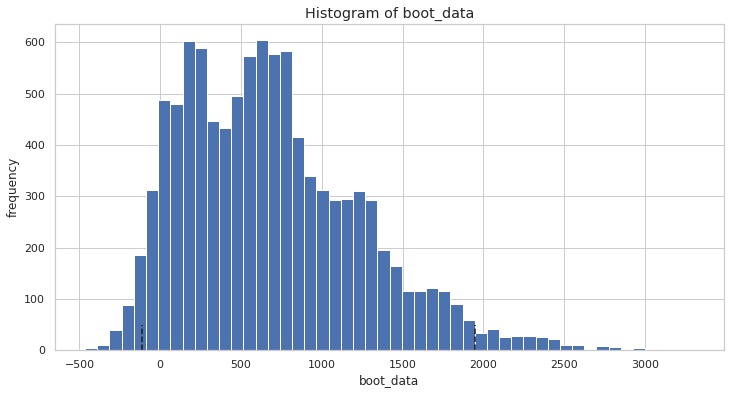

{'ci':                 0
 0.025  -113.25000
 0.975  1947.06875,
 'p_value': 0.21265233537542128}

In [92]:
get_bootstrap(other_control_1['revenue'], other_control_2['revenue'])

**A/B-тест**

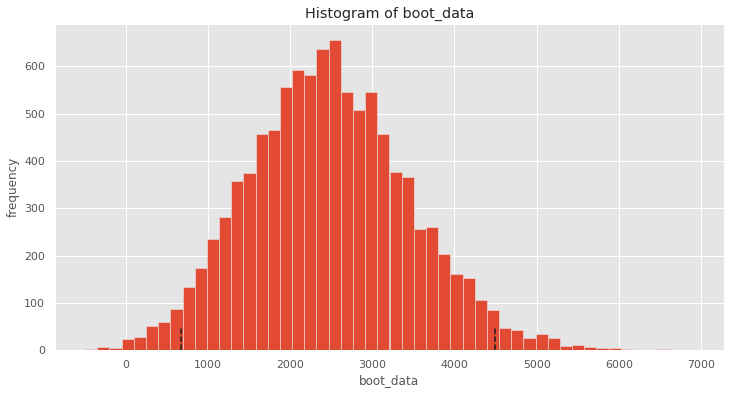

{'ci':                  0
 0.025   673.142708
 0.975  4493.940885,
 'p_value': 0.01146403218655881}

In [93]:
get_bootstrap(other_test['revenue'], other_control['revenue'])

Мы обнаружили статистически значимое различие между тестовой и контрольной группами. По показателю revenue среди покупателей дополнительных услуг.

In [94]:
print(other_test['revenue'].mean())
print(other_control['revenue'].mean())

5786.793103448276
3295.3645833333335


In [190]:
other_mult = round(5786.793103448276 / 3295.3645833333335, 2)
print(f'Среднее значение revenue среди покупателей прочих услуг в тестовой группе увеличилось в {other_mult} раз')

Среднее значение revenue среди покупателей прочих услуг в тестовой группе увеличилось в 1.76 раз


Наши пользователи стали статитстически значимо больше тратить на покупки не связанные с подписками (возможно, это покупка внутриигровой валюты, либо в приложении появились дополнительные разовые функции и сервисы).

**Промежуточный итог по результатам эксперимента**: теперь нам достоверно известно, что эксперимент снизил конверсию в покупку премиум-подписки, при этом это изменение статистически никак не повлияло на ARPU. 
Однако доходы с платящих пользователей, как от покупки премиум-подписок, так и от прочих источников - увеличились.
Нам осталось проверить ещё две метрики, чтобы сделать окончательный вывод.

## Стали ли пользователи более привлекательными друг для друга?

В конце раздела по расчёту конверсии у нас возникло предположение - изменение цены может быть связано искуственным цензом аудитории по доходу. Давайте проверим данную гипотезу и проанализирум, стали ли средние оценки коэффициента привлекательности выше в тестовой группе.

Начнём как всегда с изучения распределений.

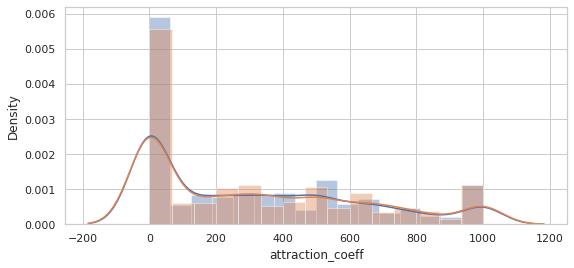

In [96]:
sns.set(rc={'figure.figsize': (9, 4)}, style="whitegrid")
sns.distplot(full_control_1['attraction_coeff'])
sns.distplot(full_control_2['attraction_coeff'])

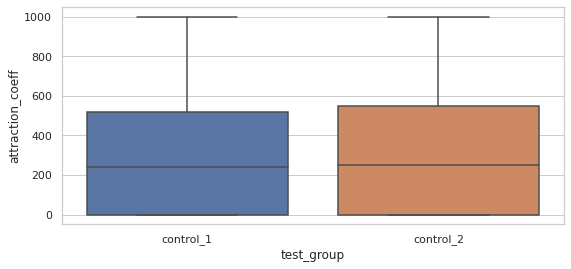

In [97]:
sns.boxplot(data=full_aa, y="attraction_coeff", x="test_group");

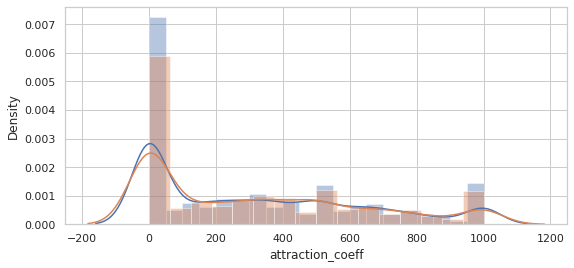

In [98]:
sns.set(rc={'figure.figsize': (9, 4)}, style="whitegrid")
sns.distplot(full_a['attraction_coeff'])
sns.distplot(full_b['attraction_coeff'])

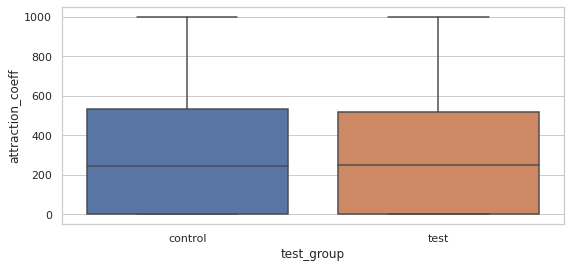

In [99]:
sns.boxplot(data=full_ab, y="attraction_coeff", x="test_group");

Мы можем увидеть распределения с несколькими вершинами, смещённые влево - то есть у нас очень много низких значений, затем чем выше оценки, тем их меньше и, наконец, есть второй пик со значениями, близкими к максимальным.

In [100]:
print(shapiro(full_a['attraction_coeff']))
print(shapiro(full_b['attraction_coeff']))
print(shapiro(full_control_1['attraction_coeff']))
print(shapiro(full_control_2['attraction_coeff']))

ShapiroResult(statistic=0.8588335514068604, pvalue=0.0)
ShapiroResult(statistic=0.8604922890663147, pvalue=0.0)
ShapiroResult(statistic=0.8593718409538269, pvalue=0.0)
ShapiroResult(statistic=0.8582068085670471, pvalue=0.0)


Ожидаемо, наши распределения не являются нормальными, поэтому используем уже знакомую нам функцию бутстрапа.

**A/A-test**

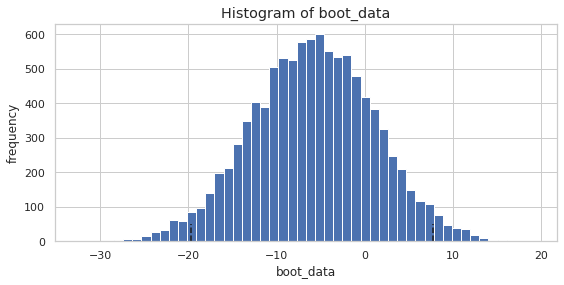

{'ci':                0
 0.025 -19.740467
 0.975   7.701619,
 'p_value': 0.39711862156430244}

In [101]:
get_bootstrap(full_control_1['attraction_coeff'], full_control_2['attraction_coeff'])

**A/B-test**

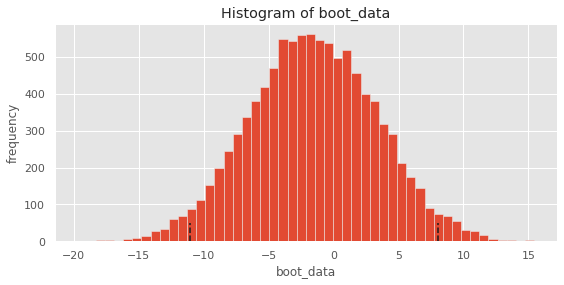

{'ci':                0
 0.025 -11.071153
 0.975   8.046563,
 'p_value': 0.7483629041857733}

In [102]:
get_bootstrap(full_a['attraction_coeff'], full_b['attraction_coeff'])

Мы не зафиксировали изменений среднего значения коэффициента привлекательности для всех пользователей, давайте взглянем на этот показатель для покупателей премиума.

In [103]:
prem_a = full_a.query('revenue > 0')
prem_b = full_b.query('revenue > 0')
prem_c1 = full_control_1.query('revenue > 0')
prem_c2 = full_control_2.query('revenue > 0')

**A/A-test**

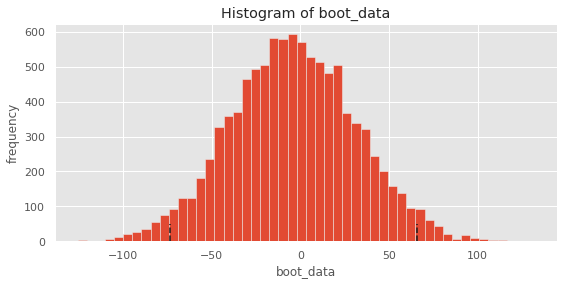

{'ci':                0
 0.025 -73.472059
 0.975  65.686520,
 'p_value': 0.9083752016535849}

In [104]:
get_bootstrap(prem_c1['attraction_coeff'], prem_c2['attraction_coeff'])

**A/B-test**

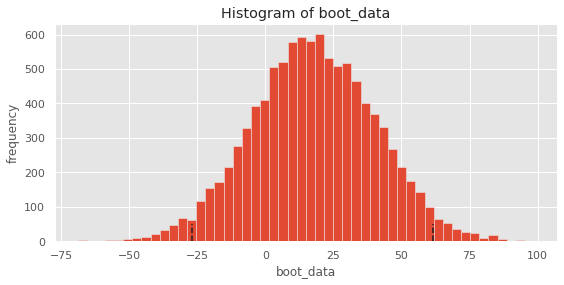

{'ci':                0
 0.025 -26.815125
 0.975  61.671375,
 'p_value': 0.43578263576673326}

In [105]:
get_bootstrap(prem_a['attraction_coeff'], prem_b['attraction_coeff'])

Для покупателей премиум-подписки изменений коэффициента привлекательности также не зафиксировано

## Retention

Цель пользователя дейтингового приложения - найти пару, однако, нам необходимо, чтобы даже если поиск оказался удачным - пользователь продолжил заходить в приложение. Можно предположить, что доступ к премиум-подписке повышает шанс мэтча, поэтому важно оценить как наш эксперимент повлиял  на retention.

In [106]:
for_retention_aa = full_aa.copy()
for_retention_ab = full_ab.copy()

In [107]:
for_retention_aa['visit4dummy'] = for_retention_aa.visit_days.astype(str).str.split(',')
for_retention_ab['visit4dummy'] = for_retention_ab.visit_days.astype(str).str.split(',')

In [108]:
for i in range(1, 90):
    for_retention_aa[f'day_{i}'] = 0
    
for index, row in for_retention_aa.iterrows():
    for day in row['visit4dummy']:
        for_retention_aa.at[index, f'day_{day}'] = 1

In [109]:
for i in range(1, 90):
    for_retention_ab[f'day_{i}'] = 0
    
for index, row in for_retention_ab.iterrows():
    for day in row['visit4dummy']:
        for_retention_ab.at[index, f'day_{day}'] = 1

In [110]:
metric_retention_aa = for_retention_aa.groupby('test_group', as_index=False)\
                                      .agg({'day_1': 'sum', 
                                            'day_3': 'sum',
                                            'day_7': 'sum', 
                                            'day_30': 'sum', 
                                            'day_60': 'sum',
                                            'day_90': 'sum', 
                                            'uid': 'count'})

metric_retention_ab = for_retention_ab.groupby('test_group', as_index=False)\
                                      .agg({'day_1': 'sum', 
                                            'day_3': 'sum',
                                            'day_7': 'sum', 
                                            'day_30': 'sum', 
                                            'day_60': 'sum',
                                            'day_90': 'sum', 
                                            'uid': 'count'})

In [111]:
metric_retention_aa['ret_1'] = round(metric_retention_aa.day_1 / metric_retention_aa.uid * 100, 2)
metric_retention_aa['ret_3'] = round(metric_retention_aa.day_3 / metric_retention_aa.uid * 100, 2)
metric_retention_aa['ret_7'] = round(metric_retention_aa.day_7 / metric_retention_aa.uid * 100, 2)
metric_retention_aa['ret_30'] = round(metric_retention_aa.day_30 / metric_retention_aa.uid * 100, 2)
metric_retention_aa['ret_60'] = round(metric_retention_aa.day_60 / metric_retention_aa.uid * 100, 2)
metric_retention_aa['ret_90'] = round(metric_retention_aa.day_90 / metric_retention_aa.uid * 100, 2)

In [112]:
metric_retention_ab['ret_1'] = round(metric_retention_ab.day_1 / metric_retention_ab.uid * 100, 2)
metric_retention_ab['ret_3'] = round(metric_retention_ab.day_3 / metric_retention_ab.uid * 100, 2)
metric_retention_ab['ret_7'] = round(metric_retention_ab.day_7 / metric_retention_ab.uid * 100, 2)
metric_retention_ab['ret_30'] = round(metric_retention_ab.day_30 / metric_retention_ab.uid * 100, 2)
metric_retention_ab['ret_60'] = round(metric_retention_ab.day_60 / metric_retention_ab.uid * 100, 2)
metric_retention_ab['ret_90'] = round(metric_retention_ab.day_90 / metric_retention_ab.uid * 100, 2)

In [113]:
metric_retention_aa

test_group  day_1  day_3  day_7  day_30  day_60  day_90   uid  ret_1  ret_3  \
0  control_1   3641   2673   1831      85      48     3.0  4340  83.89  61.59   
1  control_2   3592   2643   1809      85      48     3.0  4264  84.24  61.98   

   ret_7  ret_30  ret_60  ret_90  
0  42.19    1.96    1.11    0.07  
1  42.42    1.99    1.13    0.07

In [114]:
metric_retention_ab

test_group  day_1  day_3  day_7  day_30  day_60  day_90   uid  ret_1  ret_3  \
0    control   8030   6593   4869     256     152     8.0  8604  93.33  76.63   
1       test   4021   3302   2434     128      76     4.0  4308  93.34  76.65   

   ret_7  ret_30  ret_60  ret_90  
0  56.59    2.98    1.77    0.09  
1  56.50    2.97    1.76    0.09

In [115]:
print('Значение p-value для retention 1 дня')
print("- " * 50, "\n")
print('А/А-тест')
print(proportion.proportions_chisquare(metric_retention_aa.day_1, metric_retention_aa.uid)[1])
print("- " * 50, "\n")
print('А/B-тест')
print(proportion.proportions_chisquare(metric_retention_ab.day_1, metric_retention_ab.uid)[1])

Значение p-value для retention 1 дня
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/А-тест
0.6609441026220892
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/B-тест
0.9840790135458348


In [116]:
print('Значение p-value для retention 3 дня')
print("- " * 50, "\n")
print('А/А-тест')
print(proportion.proportions_chisquare(metric_retention_aa.day_3, metric_retention_aa.uid)[1])
print("- " * 50, "\n")
print('А/B-тест')
print(proportion.proportions_chisquare(metric_retention_ab.day_3, metric_retention_ab.uid)[1])

Значение p-value для retention 3 дня
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/А-тест
0.7067469997875462
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/B-тест
0.9788413559004783


In [117]:
print('Значение p-value для retention 7 дня')
print("- " * 50, "\n")
print('А/А-тест')
print(proportion.proportions_chisquare(metric_retention_aa.day_7, metric_retention_aa.uid)[1])
print("- " * 50, "\n")
print('А/B-тест')
print(proportion.proportions_chisquare(metric_retention_ab.day_7, metric_retention_ab.uid)[1])

Значение p-value для retention 7 дня
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/А-тест
0.8246637077899435
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/B-тест
0.9221396122871304


In [118]:
print('Значение p-value для retention 30 дня')
print("- " * 50, "\n")
print('А/А-тест')
print(proportion.proportions_chisquare(metric_retention_aa.day_30, metric_retention_aa.uid)[1])
print("- " * 50, "\n")
print('А/B-тест')
print(proportion.proportions_chisquare(metric_retention_ab.day_30, metric_retention_ab.uid)[1])

Значение p-value для retention 30 дня
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/А-тест
0.9073918024711443
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/B-тест
0.9895715169987453


In [119]:
print('Значение p-value для retention 60 дня')
print("- " * 50, "\n")
print('А/А-тест')
print(proportion.proportions_chisquare(metric_retention_aa.day_60, metric_retention_aa.uid)[1])
print("- " * 50, "\n")
print('А/B-тест')
print(proportion.proportions_chisquare(metric_retention_ab.day_60, metric_retention_ab.uid)[1])

Значение p-value для retention 60 дня
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/А-тест
0.9306423731787978
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/B-тест
0.9920137883004175


In [120]:
print('Значение p-value для retention 7 дня')
print("- " * 50, "\n")
print('А/А-тест')
print(proportion.proportions_chisquare(metric_retention_aa.day_90, metric_retention_aa.uid)[1])
print("- " * 50, "\n")
print('А/B-тест')
print(proportion.proportions_chisquare(metric_retention_ab.day_90, metric_retention_ab.uid)[1])

Значение p-value для retention 7 дня
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/А-тест
0.9827311510599455
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

А/B-тест
0.9981832124047716


Мы изучили retention 1, 3, 7, 30, 60 и 90 дней - ни в одной из групп мы не заметили статистически значимого различия между тестовой и контрольной группами

## Вывод

Мы проанализировали следующие метрики:
1. Конверсия в покупку премиум-подписки
2. Денежные метрики: изменение среднего revenue для пользователей, оплативших подписку; изменение среднего total_revenue для всех пользователей; изменение среднего revenue для покупок, не относящихся к подпискам
3. Изменение средних значений коэффециента привлекательности пользователя
4. Retention 1, 3, 7, 30, 60 и 90 дней

Изменение цены на премиум-подписку снизило конверсию в покупку в полтора раза. Судя по изменению среднего показателя выручки для пользователей, покупающих премиум-подписку, её цена увеличилась в 1.49 раз.  ARPU и ARPPU статистически не изменились, однако возросли средние показатели выручки для покупок не подписочных товаров (в 1.76 раз).

Если делать вывод о том, можно ли безболезненно повысить цену премиум-подписки, то судя по снижению конверсии - эксперимент провалился. Мы выявили, что простым повышением цены подписки достичь желаемых результатов по повышению ARPU мы не можем – ведь в таком случае просто снижается конверсия и итоговая прибыль компании не меняется.  

В будущих экспериментах я бы предложил нацелиться именно на повышение конверсии в покупку, как целевую метрику - тем более, что её показатели достаточно низкие. Для контрольной группы конверсия в покупку премиум-подписки составляет всего 2,32% - повышение даже на 1% позволит значительно увеличить прибыль без изменения цены подписки.

Другим интересным итогом эксперимента стало изменение поведения платящих пользователей – они стали больше тратить на покупки товаров, не связанных с подписочной системой, можно предположить, что это покупки внутренней валюты, либо другие дополнительные разовые функции и сервисы. Несомненно, это одна из причин, позволивших денежным метрикам в тестовой группе статистически значимо не просесть. Мы открыли для себя, что наше приложение может монетизироваться по другой схеме и итоговая выручка для компании не изменится - отличный инсайт, как минимум ради него стоило запускать этот эксперимент.

## Второй вопрос: а что по отдельным группам пользователей?

Вторым поставленным перед нами вопросом было выявить, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.
Пришло время проверить наши метрики для отдельных групп, для чего мы ранее выбрали несколько характеристик, на которые можем влиять: страна, источник трафика, пол и возраст пользователей. 

Считать мы будем следующие метрики: конверсию в покупку премиум-подписки, ARPU, retention 7 дня.

In [121]:
def groups_chi(x, groups):
    """Функция, для проверки статистической значимости изменений конверсии по группам c помощью критерия хи-квадрат"""
    p = []
    name = []
    for i in groups:
        test = x[groups == i]
        shi2stat, pval, xtable = proportion.proportions_chisquare(test.paid_users, test.all_users)
        p.append(pval)
        name.append(i)
    table = dict(zip(name, p))
    result_df = pd.DataFrame(list(table.items()), columns=['Group', 'P_value'])
    return result_df

## Конверсия

#### Влияние страны на конверсию в покупку премиум-подписки

In [122]:
conversion_country = full.groupby(['test_group', 'country'], as_index=False)\
                         .agg({'uid': 'count', 'first_paid': 'count'})\
                         .rename(columns={'uid': 'all_users', 'first_paid': 'paid_users'})
# я отфильтровал датасет по общему количеству пользователей
# поскольку для подгрупп где их слишком мало критерий не сможет выдать адекватный результат
conversion_country = conversion_country.query('all_users > 20')
conversion_country['CR'] = round(conversion_country.paid_users / conversion_country.all_users * 100, 2)
conversion_country_aa = conversion_country.query('test_group != "test"')
conversion_country_a = conversion_country_aa.groupby('country', as_index=False)\
                                            .agg({'all_users': 'sum', 'paid_users': 'sum'})
conversion_country_a['test_group'] = 'control'
conversion_country_a['CR'] = round(conversion_country_a.paid_users / conversion_country_a.all_users * 100, 2)
conversion_country_b = conversion_country.query('test_group == "test"')
conversion_country_ab = pd.concat([conversion_country_a, conversion_country_b])

##### А/A-test

In [123]:
groups_chi(conversion_country_aa, conversion_country_aa.country).query('P_value < 0.05')

Empty DataFrame
Columns: [Group, P_value]
Index: []

Статитически значимых отличий между контрольными группами не зафиксировано

##### A/B-test

In [124]:
groups_chi(conversion_country_ab, conversion_country_ab.country).query('P_value < 0.05')

Empty DataFrame
Columns: [Group, P_value]
Index: []

Статистически значимых изменений  конверсии по странам не обнаружено

#### Влияние пола пользователя на конверсию в покупку премиум-подписки

In [125]:
conversion_gender = full.groupby(['test_group', 'gender'], as_index=False)\
                        .agg({'uid': 'count', 'first_paid': 'count'})\
                        .rename(columns={'uid': 'all_users', 'first_paid': 'paid_users'})
conversion_gender['CR'] = round(conversion_gender.paid_users / conversion_gender.all_users * 100, 2)
conversion_gender_aa = conversion_gender.query('test_group != "test"')
conversion_gender_a = conversion_gender_aa.groupby('gender', as_index=False)\
                                          .agg({'all_users': 'sum', 'paid_users': 'sum'})
conversion_gender_a['test_group'] = 'control'
conversion_gender_a['CR'] = round(conversion_gender_a.paid_users / conversion_gender_a.all_users * 100, 2)
conversion_gender_b = conversion_gender.query('test_group == "test"')
conversion_gender_ab = pd.concat([conversion_gender_a, conversion_gender_b])

##### A/A-test

In [126]:
groups_chi(conversion_gender_aa, conversion_gender_aa.gender)

Group   P_value
0      0  0.029651
1      1  0.935905

In [127]:
conversion_gender_aa

test_group  gender  all_users  paid_users    CR
0  control_1       0        182           0  0.00
1  control_1       1       4158          98  2.36
2  control_2       0        195           5  2.56
3  control_2       1       4069          97  2.38

Из-за отсутствия в одной из контрольных групп женщин, купивших премиум-подписку, мы видим статистически значимое различие в конверсии. Однако, проблема здесь, вероятно, не в сплит-системе, которая при расчёте конверсии без деления на группы не давала сбоев, просто в нашем приложении слишком мало пользователей-женщин, что при допольно низкой выборке вполне могло привести к случайному смещению.

##### A/B-test

In [128]:
groups_chi(conversion_gender_ab, conversion_gender_ab.gender)

Group   P_value
0      0  0.100198
1      1  0.007355

In [129]:
conversion_gender_ab

gender  all_users  paid_users test_group    CR
0       0        377           5    control  1.33
1       1       8227         195    control  2.37
4       0        202           0       test  0.00
5       1       4106          67       test  1.63

In [130]:
round(2.37 / 1.63, 1)

1.5

Для тестовой группы мы обнаружили статистически значимое различие конверсии в покупку премиум-подписки среди мужчин - конверсия снизилась в полтора раза как и в целом по выборке, что не удивительно, потому что основными пользователями нашего приложения, принявшими участие в эксперименте, являются мужчины.

#### Влияние возраста пользователя на конверсию в покупку премиум-подписки

Чтобы распределить пользователей по возрастным группам посмотрим как они распределены в наших данных

In [131]:
users_test.age.quantile(q=[0, 0.25, 0.5, 0.75, 0.99, 1])

0.00    16.0
0.25    25.0
0.50    30.0
0.75    38.0
0.99    58.0
1.00    99.0
Name: age, dtype: float64

In [132]:
users_control_1.age.quantile(q=[0, 0.25, 0.5, 0.75, 0.99, 1])

0.00    16.0
0.25    24.0
0.50    30.0
0.75    38.0
0.99    58.0
1.00    99.0
Name: age, dtype: float64

In [133]:
users_control_2.age.quantile(q=[0, 0.25, 0.5, 0.75, 0.99, 1])

0.00    16.0
0.25    25.0
0.50    30.0
0.75    38.0
0.99    59.0
1.00    99.0
Name: age, dtype: float64

In [134]:
@vectorize
def age_groupping(age_list):
    """Данная функция разделяет выборку на группы по взрасту"""
    
    if age_list < 25:
        return 1
    elif 25 <= age_list < 30:
        return 2
    elif 30 <= age_list < 38:
        return 3
    else: 
        return 4

In [135]:
full['age_group'] = age_groupping(full.age.values)
full_a['age_group'] = age_groupping(full_a.age.values)
full_b['age_group'] = age_groupping(full_b.age.values)
full_control_1['age_group'] = age_groupping(full_control_1.age.values)
full_control_2['age_group'] = age_groupping(full_control_2.age.values)
full_aa['age_group'] = age_groupping(full_aa.age.values)
full_ab['age_group'] = age_groupping(full_ab.age.values)

In [136]:
conversion_age = full.groupby(['test_group', 'age_group'], as_index=False)\
                     .agg({'uid': 'count', 'first_paid': 'count'})\
                     .rename(columns={'uid': 'all_users', 'first_paid': 'paid_users'})
conversion_age['CR'] = round(conversion_age.paid_users / conversion_age.all_users * 100, 2)
conversion_age_aa = conversion_age.query('test_group != "test"')
conversion_age_a = conversion_age_aa.groupby('age_group', as_index=False)\
                                    .agg({'all_users': 'sum', 'paid_users': 'sum'})
conversion_age_a['test_group'] = 'control'
conversion_age_a['CR'] = round(conversion_age_a.paid_users / conversion_age_a.all_users * 100, 2)
conversion_age_b = conversion_age.query('test_group == "test"')
conversion_age_ab = pd.concat([conversion_age_a, conversion_age_b])

##### A/A-test

In [137]:
groups_chi(conversion_age_aa, conversion_age_aa.age_group)

Group   P_value
0      1  0.798465
1      2  0.829543
2      3  0.846354
3      4  0.896850

Различий между контрольными группами не обнаружено

##### A/B-test

In [138]:
groups_chi(conversion_age_ab, conversion_age_ab.age_group)

Group   P_value
0      1  0.064217
1      2  0.003958
2      3  0.826179
3      4  0.436703

In [139]:
conversion_age_ab.query('age_group == 2')

age_group  all_users  paid_users test_group    CR
1          2       1964          54    control  2.75
9          2       1053          12       test  1.14

In [140]:
print(f' Конверсия в покупку премиум подписки для пользователей от 25 до 30 лет снизилась в {round (2.75/1.14, 1)} раз')

 Конверсия в покупку премиум подписки для пользователей от 25 до 30 лет снизилась в 2.4 раз


Обнаружено статистически значимое снижение конверсии для возрастной группы от 25 до 30 лет -  а это целевая платёжеспособная аудитория любого дейтингового приложения.

## Денежные метрики

Для статистического теста  ARPU по группам мы будем использовать t-test (независимый двухвыборочный, либо двухвыборочный t-тест Уэлча в зависимости от гомогенности дисперсии). Для визуализации мы будем использовать боксплоты, однако, в силу того что ARPU включает в свой расчёт пользователей с нулевым revenue - множество нулей искажает боксплот и не даёт разобраться в характере распределения. Чтобы сделать графики понятнее, будут использованы только данные платящих пользователей - то есть визуализировать мы будем ARPPU, а не ARPU.

Для начала проверим на выбросы в данных, и если необходимо - избавимся от них, это позволит построить более понятные графики распределений (при расчёте, убирать данные значения мы не будем)

In [141]:
full_aa.query('total_revenue > 0').total_revenue.quantile(q=[0.95, 0.99, 1])

0.95     22698.00
0.99     63314.42
1.00    486330.00
Name: total_revenue, dtype: float64

In [142]:
aa_arppu_for_plot = full_aa.query('total_revenue > 0 & total_revenue < 23000')

In [143]:
full_ab.query('total_revenue > 0').total_revenue.quantile(q=[0.95, 0.99, 1])

0.95     27664.0
0.99     75647.0
1.00    486330.0
Name: total_revenue, dtype: float64

In [144]:
ab_arppu_for_plot = full_ab.query('total_revenue > 0 & total_revenue < 28000')

##### Возраст

In [145]:
def arpu_by_age(df1, df2, age_group):
    """Функция рассчитывает статистическую значимость изменения показателя ARPU по возрастным группам
    
    Функция сначала проверяет, равна ли дисперсия между одинаковыми возрастными подгруппами из разных выборок,
    используя теста Левена.
    В случае равных дисперсий используется стандартный независимый t-критерий с двумя выборками,
    если дисперсии не равны - используется t-критерий Уэлча
    """
    p = []
    name = []
    for i in age_group:
        dt1 = df1[df1["age_group"] == i]['total_revenue'].values
        dt2 = df2[df2["age_group"] == i]['total_revenue'].values
        stat_levene, p_levene = levene(dt1, dt2)
        if p_levene > 0.05:
            statistic, pval = ttest_ind(dt1, dt2, equal_var=True)
        else:
            statistic, pval = ttest_ind(dt1, dt2, equal_var=False)    
        p.append(pval)
        name.append(i)
    table = dict(zip(name, p))    
    result_df = pd.DataFrame(list(table.items()), columns=['Age_group', 'P_value'])
    return result_df

**A/A-test**

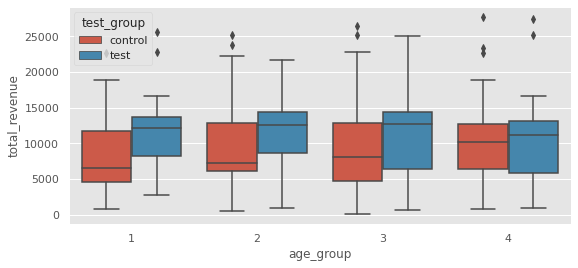

In [146]:
sns.boxplot(data=ab_arppu_for_plot, x='age_group', y='total_revenue', hue='test_group')

In [147]:
arpu_by_age_aa_result = arpu_by_age(full_control_1, full_control_2, full.age_group)

In [148]:
arpu_by_age_aa_result

Age_group   P_value
0          2  0.205274
1          4  0.508620
2          3  0.547913
3          1  0.229750

А/A - тест не обнаружил статистически значимых различий между контрольными группами в разрезе возраста

**A/B-test**

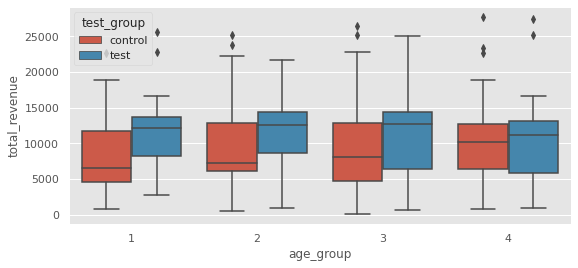

In [149]:
sns.boxplot(data=ab_arppu_for_plot, x='age_group', y='total_revenue', hue='test_group')

In [150]:
arpu_by_age_ab_result = arpu_by_age(full_b, full_a, full.age_group)

In [151]:
arpu_by_age_ab_result

Age_group   P_value
0          2  0.512849
1          4  0.330090
2          3  0.108048
3          1  0.569808

А/B - тест не обнаружил статистически значимых различий между тестовой и контрольной группами в разрезе возраста

##### Пол

In [152]:
def arpu_by_genders(df1, df2, genders):
    """Функция рассчитывает статистическую значимость изменения показателя ARPU по гендерным группам
    
    Функция сначала проверяет, равна ли дисперсия между одинаковыми гендерными подгруппами из разных выборок,
    используя теста Левена.
    В случае равных дисперсий используется стандартный независимый t-критерий с двумя выборками,
    если дисперсии не равны - используется t-критерий Уэлча
    """
    p = []
    name = []
    for i in genders:
        dt1 = df1[df1["gender"] == i]['total_revenue'].values
        dt2 = df2[df2["gender"] == i]['total_revenue'].values
        stat_levene, p_levene = levene(dt1, dt2)
        if p_levene > 0.05:
            statistic, pval = ttest_ind(dt1, dt2, equal_var=True)
        else:
            statistic, pval = ttest_ind(dt1, dt2, equal_var=False)    
        p.append(pval)
        name.append(i)
    table = dict(zip(name, p))    
    result_df = pd.DataFrame(list(table.items()), columns=['Gender', 'P_value'])
    return result_df

**A/A-test**

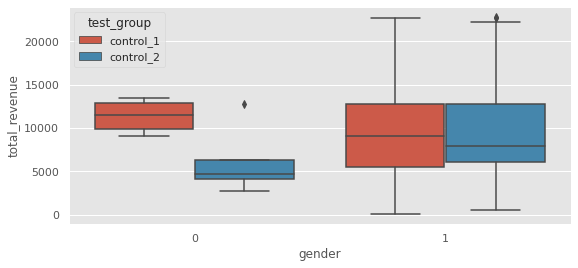

In [153]:
sns.boxplot(data=aa_arppu_for_plot, x='gender', y='total_revenue', hue='test_group')

In [154]:
arpu_by_gender_aa_result = arpu_by_genders(full_control_1, full_control_2, full.gender)

In [155]:
arpu_by_gender_aa_result

Gender   P_value
0       1  0.275157
1       0  0.792358

А/A - тест не обнаружил статистически значимых различий между контрольными группами по полу

**A/B-test**

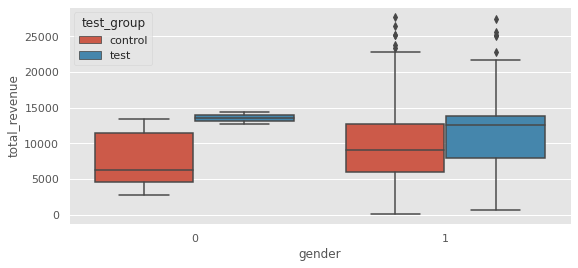

In [156]:
sns.boxplot(data=ab_arppu_for_plot, x='gender', y='total_revenue', hue='test_group')

In [157]:
arpu_by_gender_ab_result = arpu_by_genders(full_b, full_a, full.gender)

In [158]:
arpu_by_gender_ab_result

Gender   P_value
0       1  0.874315
1       0  0.446960

А/B - тест не обнаружил статистически значимых различий между тестовой и контрольной группами по полу

##### Страна

In [159]:
def arpu_by_country(df1, df2, countries):
    """Функция рассчитывает статистическую значимость изменения показателя ARPU по странам
    
    Функция сначала проверяет, равна ли дисперсия между одинаковыми странами из разных выборок,
    используя теста Левена.
    В случае равных дисперсий используется стандартный независимый t-критерий с двумя выборками,
    если дисперсии не равны - используется t-критерий Уэлча
    """
    p = []
    name = []
    for i in countries:
        dt1 = df1[df1["country"] == i]['total_revenue'].values
        dt2 = df2[df2["country"] == i]['total_revenue'].values
        stat_levene, p_levene = levene(dt1, dt2)
        if p_levene > 0.05:
            statistic, pval = ttest_ind(dt1, dt2, equal_var=True)
        else:
            statistic, pval = ttest_ind(dt1, dt2, equal_var=False)    
        p.append(pval)
        name.append(i)
    table = dict(zip(name, p))    
    result_df = pd.DataFrame(list(table.items()), columns=['Country', 'P_value'])
    return result_df

**A/A-test**

In [160]:
fig = px.box(aa_arppu_for_plot, x="country", y="total_revenue", color="test_group")
fig.update_traces(quartilemethod="exclusive")
fig.show()

In [161]:
arpu_by_country_aa_result = arpu_by_country(full_control_1, full_control_2, full.country)

In [162]:
arpu_by_country_aa_result.query('P_value < 0.05')

Empty DataFrame
Columns: [Country, P_value]
Index: []

А/A - тест не обнаружил статистически значимых различий между контрольными группами в разрезе стран

**A/B-test**

In [163]:
fig = px.box(ab_arppu_for_plot, x="country", y="total_revenue", color="test_group")
fig.update_traces(quartilemethod="exclusive")
fig.show()

In [164]:
arpu_by_country_ab_result = arpu_by_country(full_b, full_a, full.country)

In [165]:
arpu_by_country_ab_result.query('P_value < 0.05')

Empty DataFrame
Columns: [Country, P_value]
Index: []

A/B-тест также не обнаружил статистически значимых различий между тестовой и контрольной группами в разрезе стран

##### Источник трафика

Для пользователей, совершивших покупки, мы также можем посмотреть зависимость ARPPU от источника трафика (поскольку эта переменная нам известна только для совершивших транзакции)

In [166]:
def arppu_by_from_page(df1, df2, from_page):
    """Функция рассчитывает статистическую значимость изменения показателя ARPPU по источникам трафика
    
    Функция сначала проверяет, равна ли дисперсия между одинаковыми группами по исчтонику трафика из разных выборок,
    используя теста Левена.
    В случае равных дисперсий используется стандартный независимый t-критерий с двумя выборками,
    если дисперсии не равны - используется t-критерий Уэлча
    """
    p = []
    name = []
    for i in from_page:
        dt1 = df1[df1["from_page"] == i].query('revenue > 0')['total_revenue'].values
        dt2 = df2[df2["from_page"] == i].query('revenue > 0')['total_revenue'].values
        stat_levene, p_levene = levene(dt1, dt2)
        if p_levene > 0.05:
            statistic, pval = ttest_ind(dt1, dt2, equal_var=True)
        else:
            statistic, pval = ttest_ind(dt1, dt2, equal_var=False)    
        p.append(pval)
        name.append(i)
    table = dict(zip(name, p))    
    result_df = pd.DataFrame(list(table.items()), columns=['from_page', 'P_value'])
    return result_df

**A/A-test**

In [167]:
arppu_from_page_aa_result = arppu_by_from_page(full_control_1,
                                               full_control_2, 
                                               full.from_page)

In [168]:
arppu_from_page_aa_result.query('P_value < 0.05')

Empty DataFrame
Columns: [from_page, P_value]
Index: []

А/A - тест не обнаружил статистически значимых различий между контрольными группами в разрезе источника трафика

**A/B-test**

In [169]:
arppu_from_page_ab_result = arppu_by_from_page(full_b,
                                               full_a, 
                                               full.from_page)

In [170]:
arppu_from_page_ab_result.query('P_value < 0.05')

from_page   P_value
1              dating  0.021848
2  popular_users_chat  0.034637

In [171]:
full_a.groupby('from_page', as_index=False).agg({'total_revenue': 'mean'})\
      .query('from_page in ["dating", "popular_users_chat"]')

from_page  total_revenue
1              dating    8821.583333
7  popular_users_chat    8611.200000

In [172]:
full_b.groupby('from_page', as_index=False).agg({'total_revenue': 'mean'})\
      .query('from_page in ["dating", "popular_users_chat"]')

from_page  total_revenue
1              dating       14539.20
7  popular_users_chat       29968.25

In [173]:
14539.20 / 8821.583333

1.6481395063867272

In [174]:
29968.25 / 8611.200000

3.480147946859903

А/B - обнаружил статистически значимые различий между тестовой и контрольной группами из источников: dating и popular_users_chat   

## Retention по группам

In [175]:
def retention_7_chi(data, groups):
    """Проверка статистической значимости изменений retention 7 дня и по группам с помощью критегия хи-квадрат"""
    
    p = []
    name = []
    for i in groups:
        test = data[groups == i]
        shi2stat, pval, xtable = proportion.proportions_chisquare(test.day_7, test.uid)
        p.append(pval)
        name.append(i)
    table = dict(zip(name, p))
    result_df = pd.DataFrame(list(table.items()), columns=['Group', 'P_value'])
    return result_df

### Возраст

In [176]:
for_retention_aa['age_group'] = age_groupping(for_retention_aa.age.values)
for_retention_ab['age_group'] = age_groupping(for_retention_ab.age.values)

In [177]:
age_retention_aa = for_retention_aa.groupby(['test_group', 'age_group'], as_index=False)\
                                   .agg({'day_7': 'sum', 'uid': 'count'})
age_retention_ab = for_retention_ab.groupby(['test_group', 'age_group'], as_index=False)\
                                   .agg({'day_7': 'sum', 'uid': 'count'})

##### A/A-test

In [178]:
retention_7_chi(data=age_retention_aa, groups=age_retention_aa.age_group)

Group   P_value
0      1  0.300203
1      2  0.436756
2      3  0.626215
3      4  0.400594

Различий между контрольными группами не обнаружено

##### A/B-test

In [179]:
retention_7_chi(data=age_retention_ab, groups=age_retention_ab.age_group)

Group   P_value
0      1  0.972329
1      2  0.279440
2      3  0.749920
3      4  0.575027

Между тестовой и контрольной группой различий также не обнаружено

### Пол

In [180]:
gender_retention_aa = for_retention_aa.groupby(['test_group', 'gender'], as_index=False)\
                                      .agg({'day_7': 'sum', 'uid': 'count'})
gender_retention_ab = for_retention_ab.groupby(['test_group', 'gender'], as_index=False)\
                                      .agg({'day_7': 'sum', 'uid': 'count'})

##### A/A-test

In [181]:
retention_7_chi(data=gender_retention_aa, groups=gender_retention_aa.gender)

Group   P_value
0      0  0.748196
1      1  0.758250

Различий между контрольными группами не обнаружено

##### A/B-test

In [182]:
retention_7_chi(data=gender_retention_ab, groups=gender_retention_ab.gender)

Group   P_value
0      0  0.853336
1      1  0.964239

Между тестовой и контрольной группой различий также не обнаружено

#### Страна

In [183]:
country_retention_aa = for_retention_aa.groupby(['test_group', 'country'], as_index=False)\
                                       .agg({'day_7': 'sum', 'uid': 'count'})\
                                       .query('uid > 30')
country_retention_ab = for_retention_ab.groupby(['test_group', 'country'], as_index=False)\
                                       .agg({'day_7': 'sum', 'uid': 'count'})\
                                       .query('uid > 30')

##### A/A-test

In [184]:
retention_7_chi(data=country_retention_aa, groups=country_retention_aa.country).query('P_value < 0.05')

Empty DataFrame
Columns: [Group, P_value]
Index: []

Различий между контрольными группами не обнаружено

##### A/B-test

In [185]:
country_retention_ab['retention'] = round(country_retention_ab.day_7 / country_retention_ab.uid * 100, 2)

In [186]:
retention_7_chi(data=country_retention_ab, groups=country_retention_ab.country).query('P_value < 0.05')

Group   P_value
4  Chile  0.020648

In [187]:
country_retention_ab.query('country == "Chile"')

test_group country  day_7  uid  retention
9     control   Chile    335  573      58.46
66       test   Chile    136  272      50.00

In [188]:
100 - (50.00 / 58.46 * 100)

14.471433458775223

Обнаружены статистически значимые изменения retenton 7 дня для Чили, retention 7 дня упал примерно на 15%

## Итоговые выводы по результатам эксперимента

Эксперимент показал статистически значимое снижение конверсии в покупку премиум-подписки в 1,5 раза. Однако, ARPU  и ARPPU не изменились, как потому, что цена поднялась, так и за счёт того, что пользователи стали чаще покупать другие услуги. Средний чек для других услуг увеличился в в 1,76 раз. Иначе говоря, пользователи изменили своё поведение и вместо подписки стали платить за другие функции сервиса, чтобы получать доступ к максимальному функционалу. Retention 7-ого дня также не изменился.<br>

Что касается распределений по отдельным группам пользователей, то были зафиксированы следующие статистически значимые изменения:<br>
1) Конверсия в покупку премиум-подписку среди мужчин снизилась в 1,5 раза<br>
2) Конверсия в покупку премиум-подписку для пользователей от 25 до 30 лет снизилась в 2.4 раз<br>
3) Средний чек для покупателей, пришедших с источника "dating" увеличился в 1,65 раза, а для "popular_users_chat" увеличился в 3,5 раза<br>
4) Retention 7 дня для пользователей из Чили упал примерно на 14,5%<br>

Вывод: как в целом по выборке, так и по отдельным группам эксперимент показал скорее негативные результаты и может быть признан неудачным – выкатывать изменения на всех пользователей я бы не рекомендовал. 

Также можно выделить 2 инсайта, которые удалось получить благодаря эксперименту:<br>
1) В эксперименте обнаружена огромная диспропорция мужчин и женщин – практически 20 к 1. Необходимо совершенствовать сервис таким образом, чтобы им пользовалось больше женщин – это огромная неиспользованная рыночная ниша, однако выход на него потребует качественных изменений.<br>
2) Поведение пользователей достаточно гибкое, даже в случае изменения цены на привычные продукты они находят альтернативные возможности для получения максимального функционала. В эксперименте мы увидели успешную модель монетезации через единичные дополнительные транзакции – это также пространство для развития.<br>
3) Каналы "dating" и "popular_users_chat" показали высокую эффективность в повышении среднего чека в тестовой группе, необходимо лучше изучить рекламные кампании, производимые через эти каналы для выявления того, какие действия к этому превели.